# Markov chains for xT 

Here, we are trying to assign value to each action a player takes on the pitch. We do this by looking at how much a player's action has affected the probability of their team scoring a goal. eg. If a player gets the ball in midfield where the chances of a goal happening is 5% and they swing a cross into the box which increases the probability of their team scoring from 5% to 35% then the player has 0.35-0.05 added to their value on the pitch

In [1]:
import numpy as np

In [2]:
#setting up the matrix
#we first set up the pass matrix A and the goal vector g.

A = np.matrix([[0.25,0.20,0.1],[0.1,0.25,0.2],[0.1,0.1,0.25]])
g = np.transpose(np.matrix([0.05,0.15,0.05]))

There are three methods of solving for the expected threat.
1. Linear Algebra method -> (I-A)xT = g
2. Iterative method -> xT' = A xT + g
3. Simulation method -> where simulate num_sim possessions, starting from each of the three areas. 

## Linear Algebra method

In [3]:
xT1 = np.linalg.solve(np.identity(3) - A,g)

print('Expected Threat')
print('Central, Box, Wing')
print(np.transpose(xT1))

Expected Threat
Central, Box, Wing
[[0.14991763 0.25205931 0.12026359]]


## Iterative method

In [4]:
xT2 = np.zeros((3,1))
for t in range(10):
    print(np.matmul(A, xT2) + g)
    xT2 = np.matmul(A, xT2) + g

print('Expected Threat')
print('Central, Box, Wing')
print(np.transpose(xT2))

[[0.05]
 [0.15]
 [0.05]]
[[0.0975]
 [0.2025]
 [0.0825]]
[[0.123125]
 [0.226875]
 [0.100625]]
[[0.13621875]
 [0.23915625]
 [0.11015625]]
[[0.14290156]
 [0.24544219]
 [0.11507656]]
[[0.14632148]
 [0.24866602]
 [0.11760352]]
[[0.14807393]
 [0.25031936]
 [0.11889963]]
[[0.14897232]
 [0.25116716]
 [0.11956424]]
[[0.14943293]
 [0.25160187]
 [0.11990501]]
[[0.14966911]
 [0.25182476]
 [0.12007973]]
Expected Threat
Central, Box, Wing
[[0.14966911 0.25182476 0.12007973]]


## Simulation method

In [5]:
num_sims = 10
xT3 = np.zeros(3)

description = {0:'Central', 1:'Wing', 2:'Box'}

for i in range(3):
    num_goals = 0

    print('------------------')
    print('Start from '+ description[i])
    print('------------------')

    for n in range(num_sims):

        ballinplay = True
        #Initial state is i
        s = i
        describe_possession = ''

        while ballinplay:
            r=np.random.rand()

            #make commentary text
            describe_possession = describe_possession + ' - ' + description[s]


            #cumulative sum of in play probabilities
            c_sum=np.cumsum(A[s,:])
            new_s = np.sum(r>c_sum)
            if new_s>2:
                #ball is either goal or out of play
                ballinplay = False
                if r < g[s] + c_sum[0,2]:
                    #its a goal!
                    num_goals = num_goals+1
                    describe_possession = describe_possession + ' - Goal!'
                else:
                    describe_possession = describe_possession + ' - Out of play'
            s= new_s

        print(describe_possession)
    
    xT3[i] = num_goals/num_sims


print('\n\n---------------')
print('Expected Threat')
print('Central, Box, Wing')
print(np.transpose(xT3))

------------------
Start from Central
------------------
 - Central - Out of play
 - Central - Out of play
 - Central - Central - Out of play
 - Central - Out of play
 - Central - Out of play
 - Central - Out of play
 - Central - Out of play
 - Central - Wing - Goal!
 - Central - Out of play
 - Central - Out of play
------------------
Start from Wing
------------------
 - Wing - Out of play
 - Wing - Goal!
 - Wing - Out of play
 - Wing - Out of play
 - Wing - Goal!
 - Wing - Out of play
 - Wing - Out of play
 - Wing - Out of play
 - Wing - Wing - Out of play
 - Wing - Out of play
------------------
Start from Box
------------------
 - Box - Box - Central - Out of play
 - Box - Box - Out of play
 - Box - Box - Box - Out of play
 - Box - Wing - Wing - Wing - Goal!
 - Box - Box - Out of play
 - Box - Out of play
 - Box - Box - Out of play
 - Box - Out of play
 - Box - Out of play
 - Box - Out of play


---------------
Expected Threat
Central, Box, Wing
[0.1 0.2 0.1]


 # Calcuating xT (position-based) 

In [6]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import os
import pathlib
import warnings
from mplsoccer import Pitch
from scipy.stats import binned_statistic_2d

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [7]:
df = pd.read_json(r'C:\Users\elvin\Documents\Soccermatics\Wyscout\events\events_England.json')

## Actions moving the ball

To calculate the Expected Threat we need actions that move the ball. First we filter them from the database. Then, we remove passes that ended out of the pitch. To make our calculations easier we create new columns with coordinates, one for each coordinate. Then, we plot the location of actions moving the ball on 2D histogram. Note that dribbling is also an action that moves the ball. However, Wyscout does not store them in the v2 version that we are using in the course and not all ground attacking duels are dribblings. In the end we store number of actions in each bin in a move_count array to calculate later move probability.

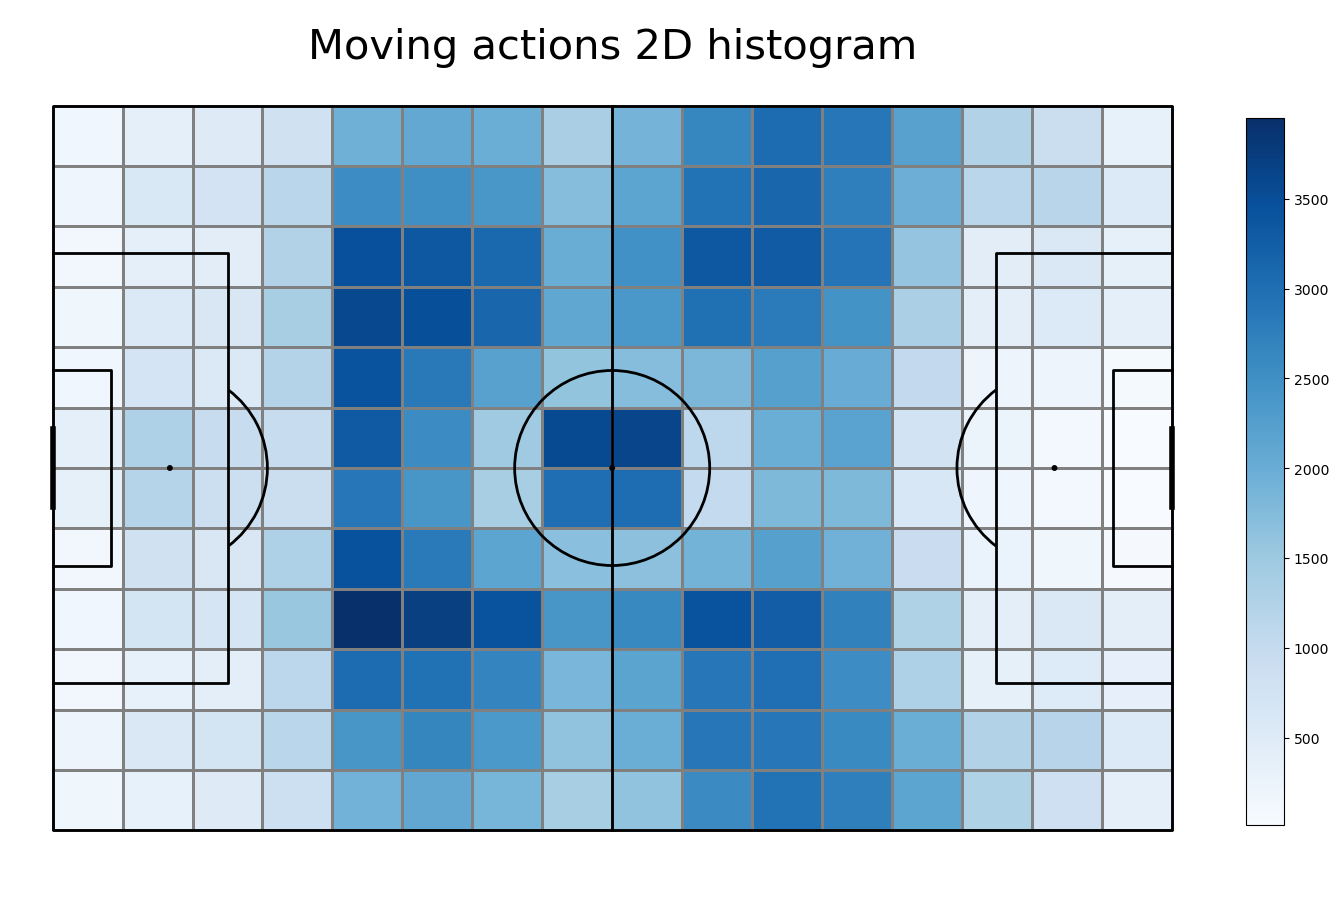

In [8]:
next_event = df.shift(-1,fill_value=0)
df['nextEvent'] = next_event['subEventName']

df['kickedOut'] = df.apply(lambda x: 1 if x.nextEvent == 'Ball out of the field' else 0, axis=1)
move_df = df.loc[df['subEventName'].isin(['Simple pass', 'High pass', 'Head pass', 'Smart pass', 'Cross'])]
#filtering out of field
delete_passes = move_df.loc[move_df['kickedOut']==1]
move_df = move_df.drop(delete_passes.index)

#extracting the coordinates
move_df['x'] = move_df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
move_df['y'] = move_df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
move_df['end_x'] = move_df.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
move_df['end_y'] = move_df.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100)
move_df = move_df.loc[(((move_df['end_x'] != 0) & (move_df['end_y'] != 68)) & ((move_df['end_x'] != 105) & (move_df['end_y'] != 0)))]

#creating a 2D histogram of these
pitch = Pitch(line_color='black', pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder=2)
move = pitch.bin_statistic(move_df.x, move_df.y, statistic='count', bins=(16,12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height= 0.04, title_space=0, endnote_space=0)
pcm = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])
#adding the legend
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Moving actions 2D histogram', fontsize = 30)
plt.show()
move_count = move['statistic']

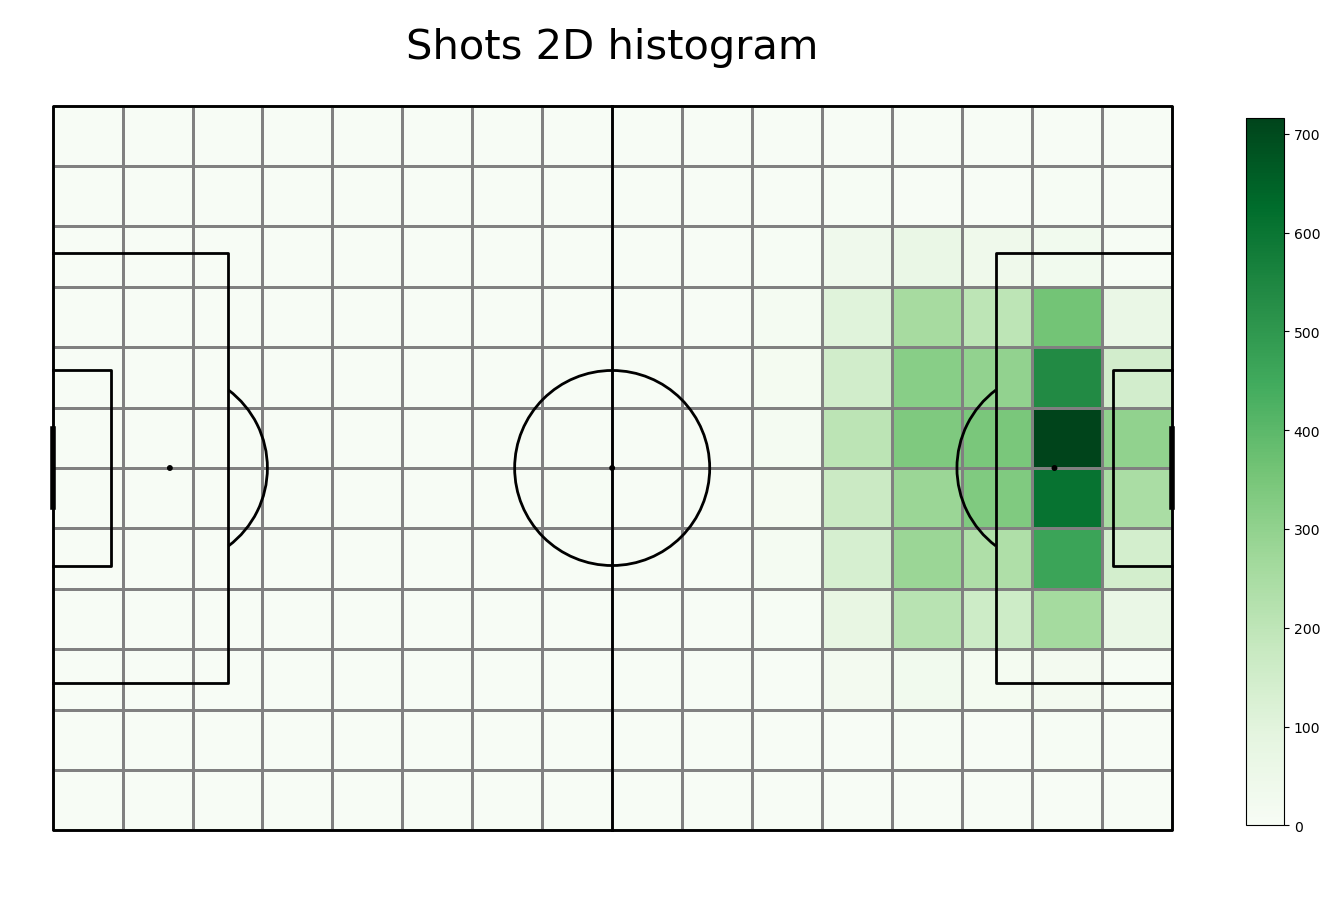

In [9]:
shot_df = df[df['subEventName']=='Shot']
shot_df['x'] =  shot_df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
shot_df['y'] =  shot_df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)

#2D histogram of shots
shot = pitch.bin_statistic(shot_df.x,shot_df.y, statistic='count', bins=(16,12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])

ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shots 2D histogram', fontsize = 30)
plt.show()

shot_count = shot['statistic']

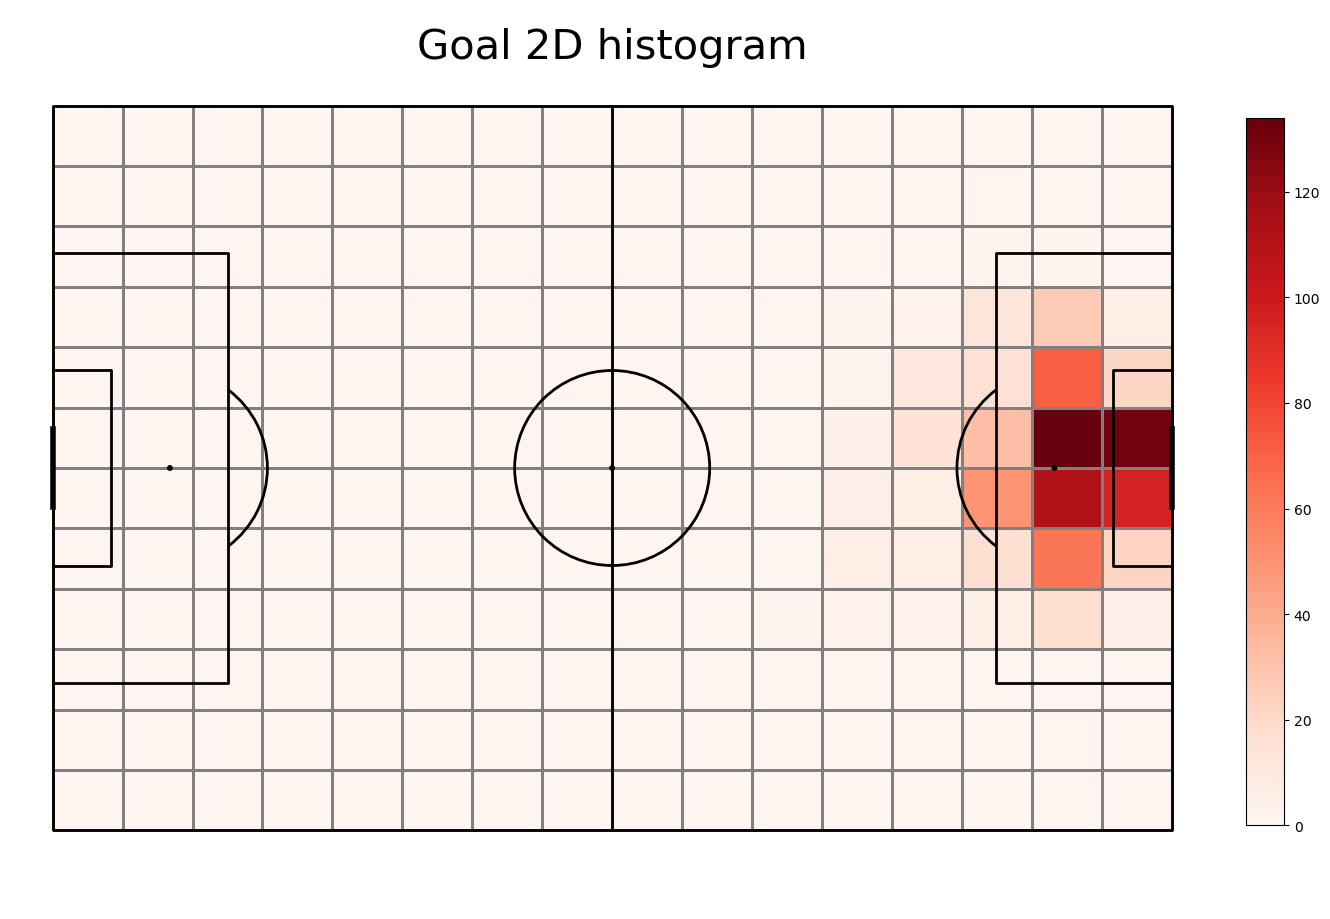

In [10]:
goal_df = shot_df[shot_df.apply(lambda x: {'id': 101} in x.tags, axis=1)]
goal = pitch.bin_statistic(goal_df.x,goal_df.y, statistic='count', bins=(16,12), normalize=False)
goal_count = goal['statistic']

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])

ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal 2D histogram', fontsize = 30)
plt.show()

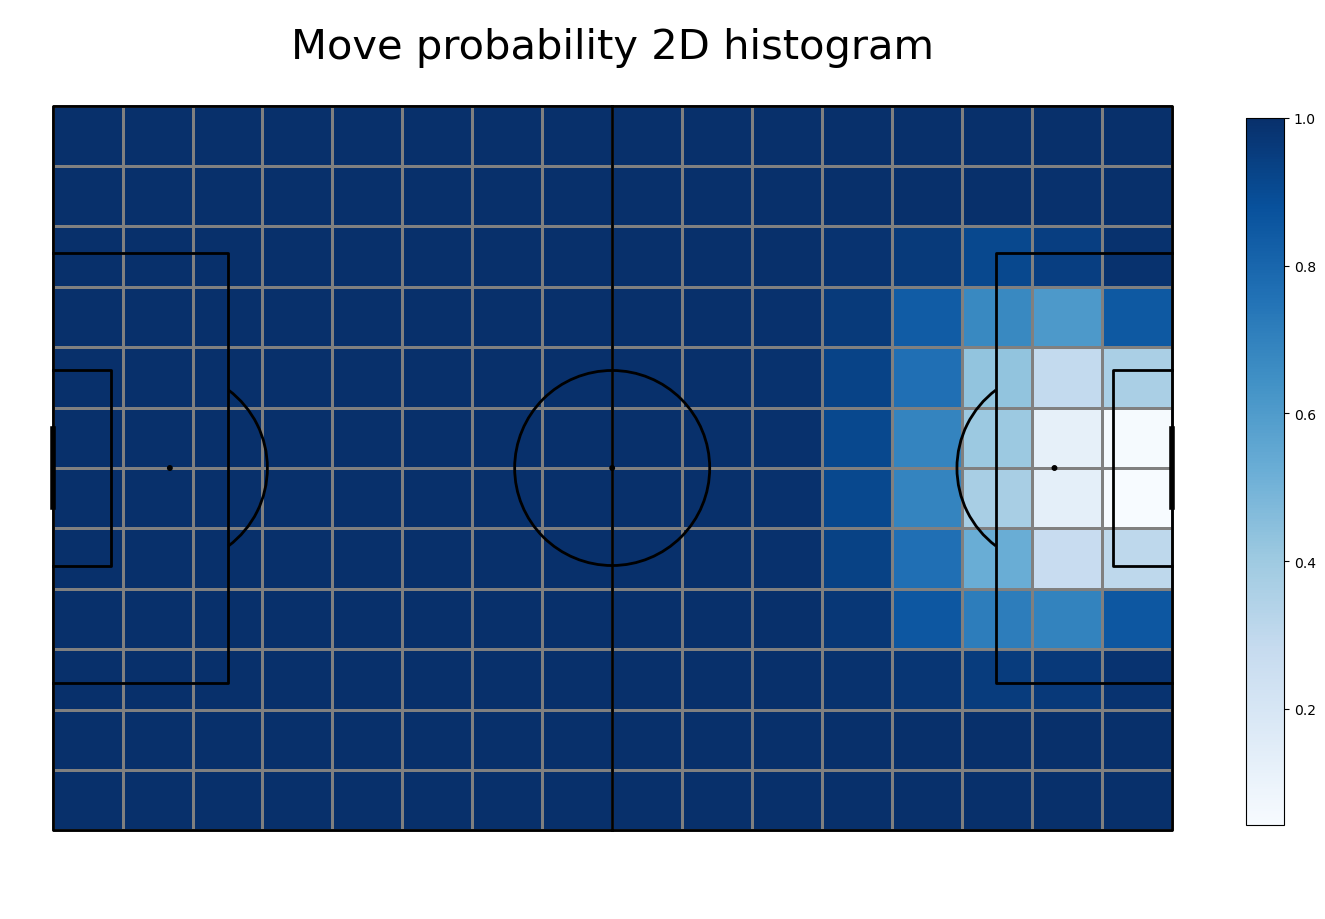

In [11]:
#Calculating the move probability
move_probability = move_count/(move_count+shot_count)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
move['statistic'] = move_probability
pcm = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])

ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Move probability 2D histogram', fontsize = 30)
plt.show()

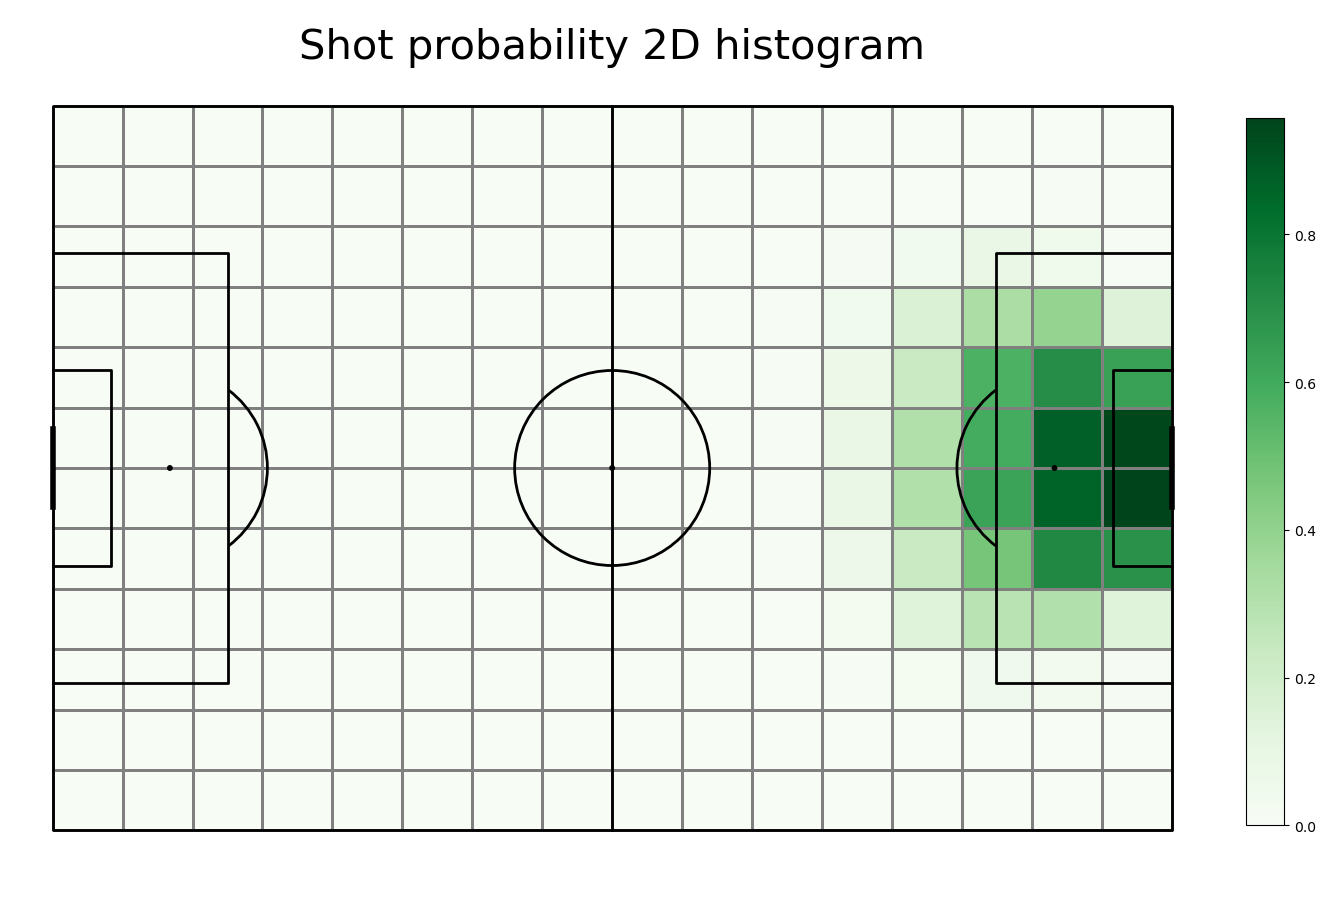

In [12]:
#calculating the shot probability
shot_probability = 1 - move_probability

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
shot['statistic'] = shot_probability
pcm = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])

ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shot probability 2D histogram', fontsize = 30)
plt.show()

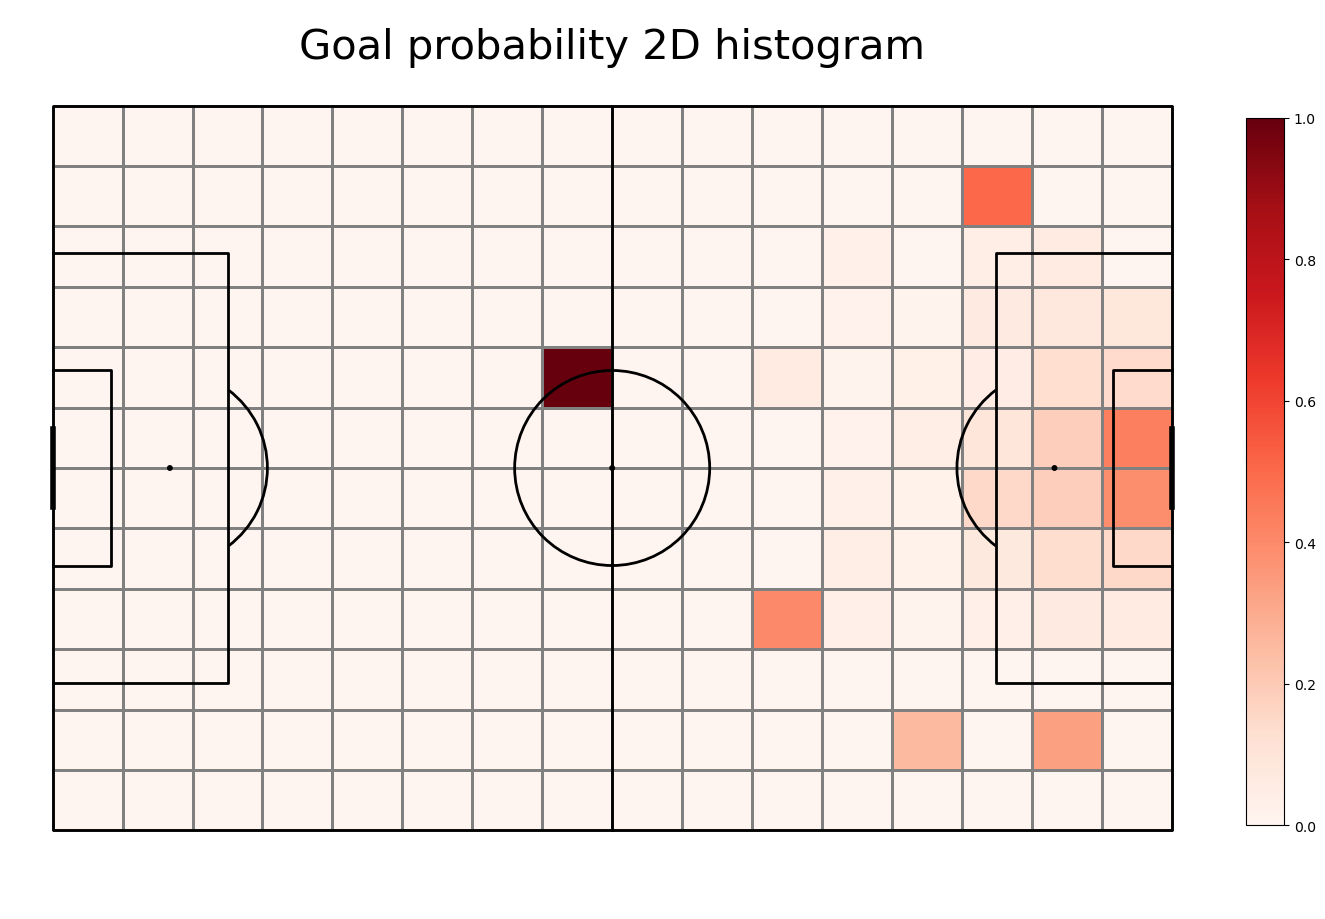

In [13]:
# calculating goal probability
goal_probability = goal_count/shot_count
goal_probability[np.isnan(goal_probability)] = 0

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
goal['statistic'] = goal_probability
pcm = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])

ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal probability 2D histogram', fontsize = 30)
plt.show()

## Transition matirices
For each of 192 sectors we need to calculate a transition matrix - a matrix of probabilities going from one zone to another one given that the ball was moved. First, we create another columns in the move_df with the bin on the histogram that the event started and ended in. Then, we group the data by starting sector and count starts from each of them. As the next step, for each of the sectors we calculate the probability of transfering the ball from it to all 192 sectors on the pitch. given that the ball was moved. We do it as the division of events that went to the end sector by all events that started in the starting sector. As the last step, we vizualize the transition matrix for the sector in the bottom left corner of the pitch.

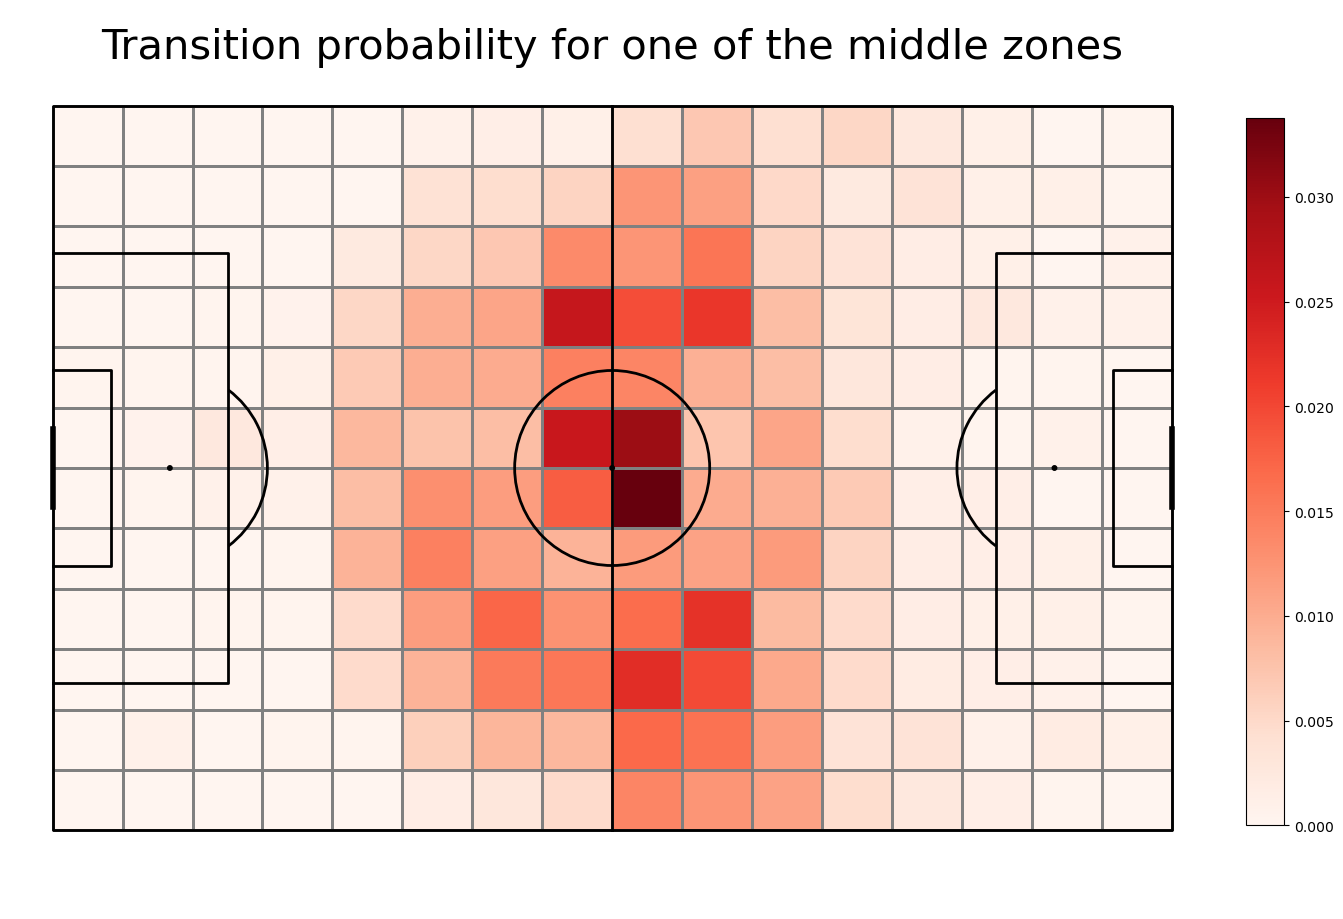

In [14]:
#move start index
move_df['start_sector'] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.x), np.ravel(row.y),
                                                                                            values="None", statistic="count",
                                                                                            bins=(16,12), range=[[0,105],[0,68]],
                                                                                            expand_binnumbers=True)[3]]), axis=1)

#move end index
move_df['end_sector'] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.end_x), np.ravel(row.end_y),
                                                                                            values="None", statistic="count",
                                                                                            bins=(16,12), range=[[0,105],[0,68]],
                                                                                            expand_binnumbers=True)[3]]), axis=1)

#df with summed events from each index
df_count_starts = move_df.groupby(['start_sector'])['eventId'].count().reset_index()
df_count_starts.rename(columns= {'eventId':'count_starts'}, inplace=True)

transition_matrices = []
for i, row in df_count_starts.iterrows():
    start_sector = row['start_sector']
    count_starts = row['count_starts']
    #get all the events that started in this sector
    this_sector = move_df[move_df['start_sector']==start_sector]
    df_count_ends = this_sector.groupby(['end_sector'])['eventId'].count().reset_index()
    df_count_ends.rename(columns= {'eventId':'count_ends'}, inplace=True)
    T_matrix = np.zeros((12,16))
    for j, row2 in df_count_ends.iterrows():
        end_sector = row2['end_sector']
        value = row2['count_ends']
        T_matrix[end_sector[1] - 1][end_sector[0] - 1]= value
    T_matrix = T_matrix / count_starts
    transition_matrices.append(T_matrix)

#plotting for zone(1,1) - left bottom corner
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

#change the index here to change the zone
goal['statistic'] = transition_matrices[90]
pcm = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])

ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Transition probability for one of the middle zones', fontsize = 30)
plt.show()

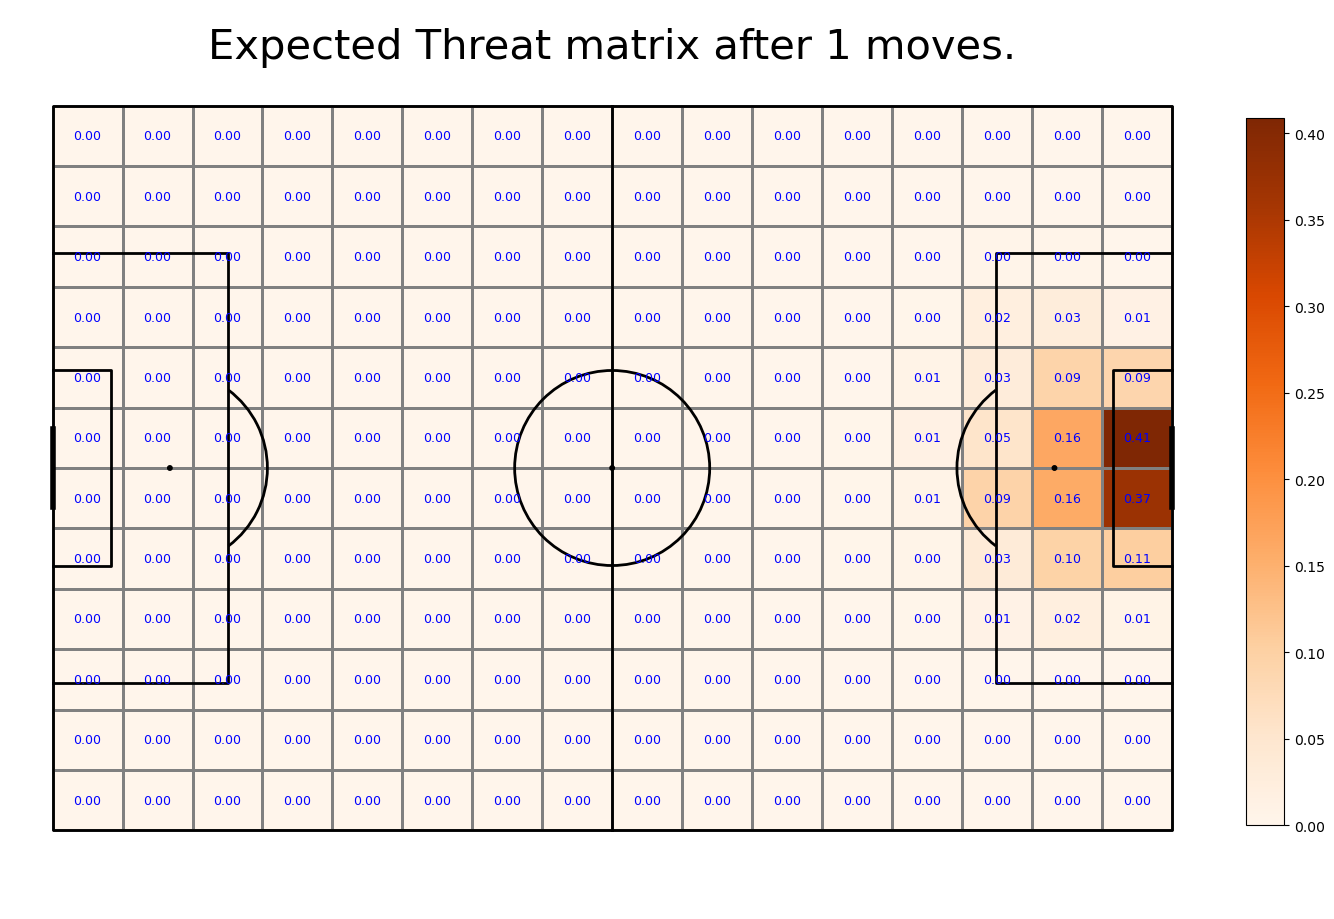

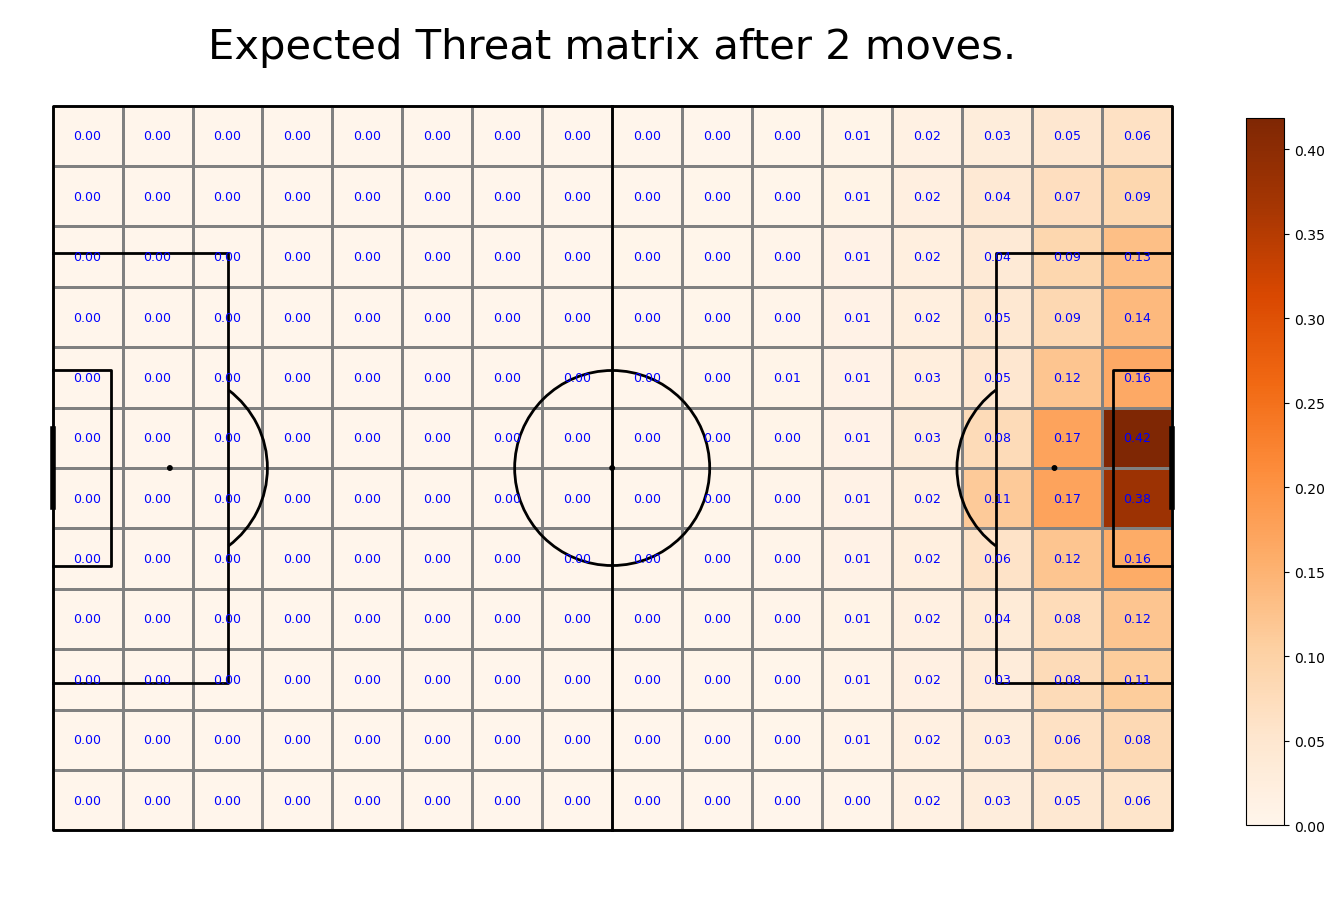

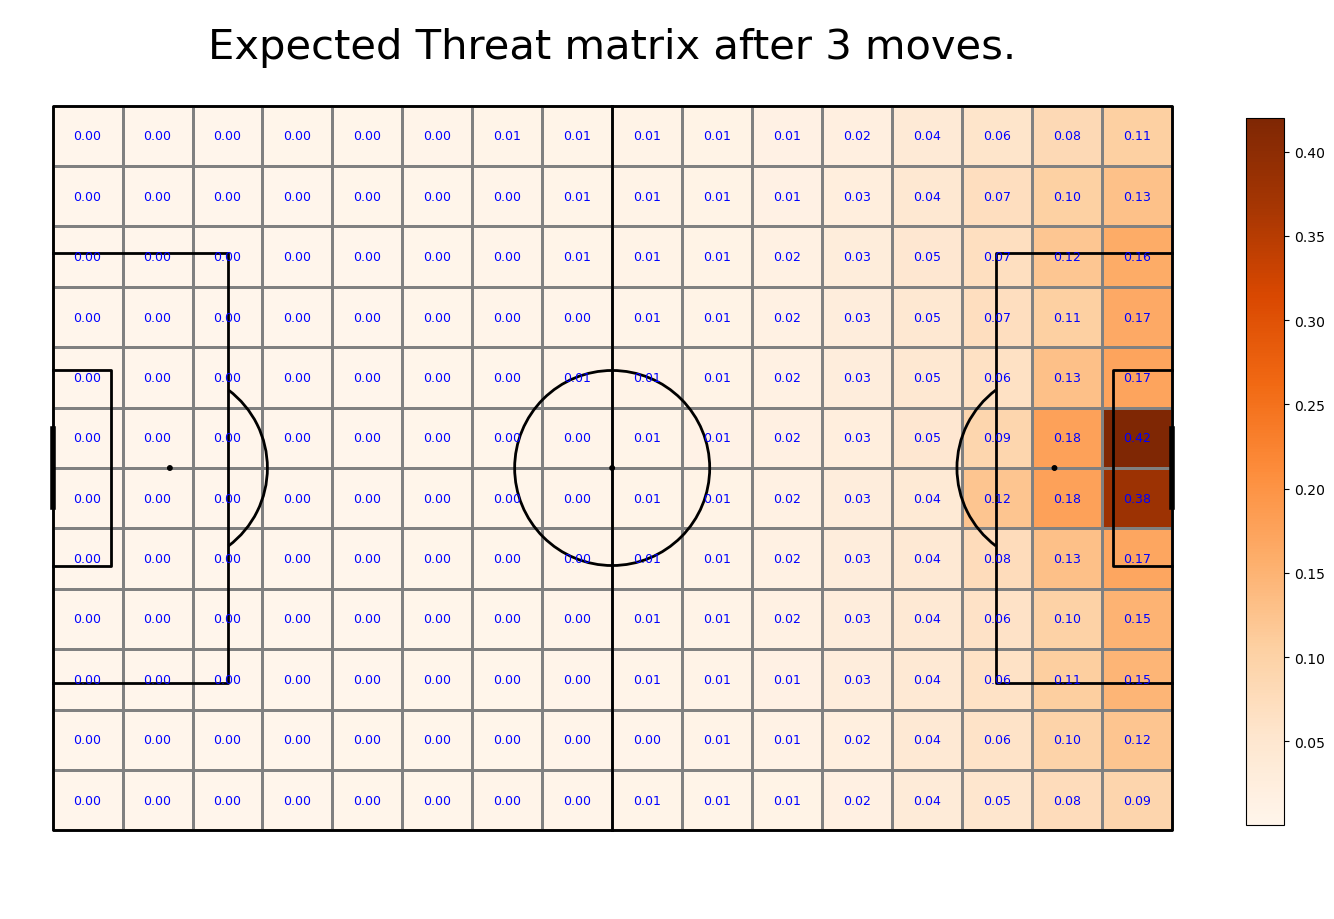

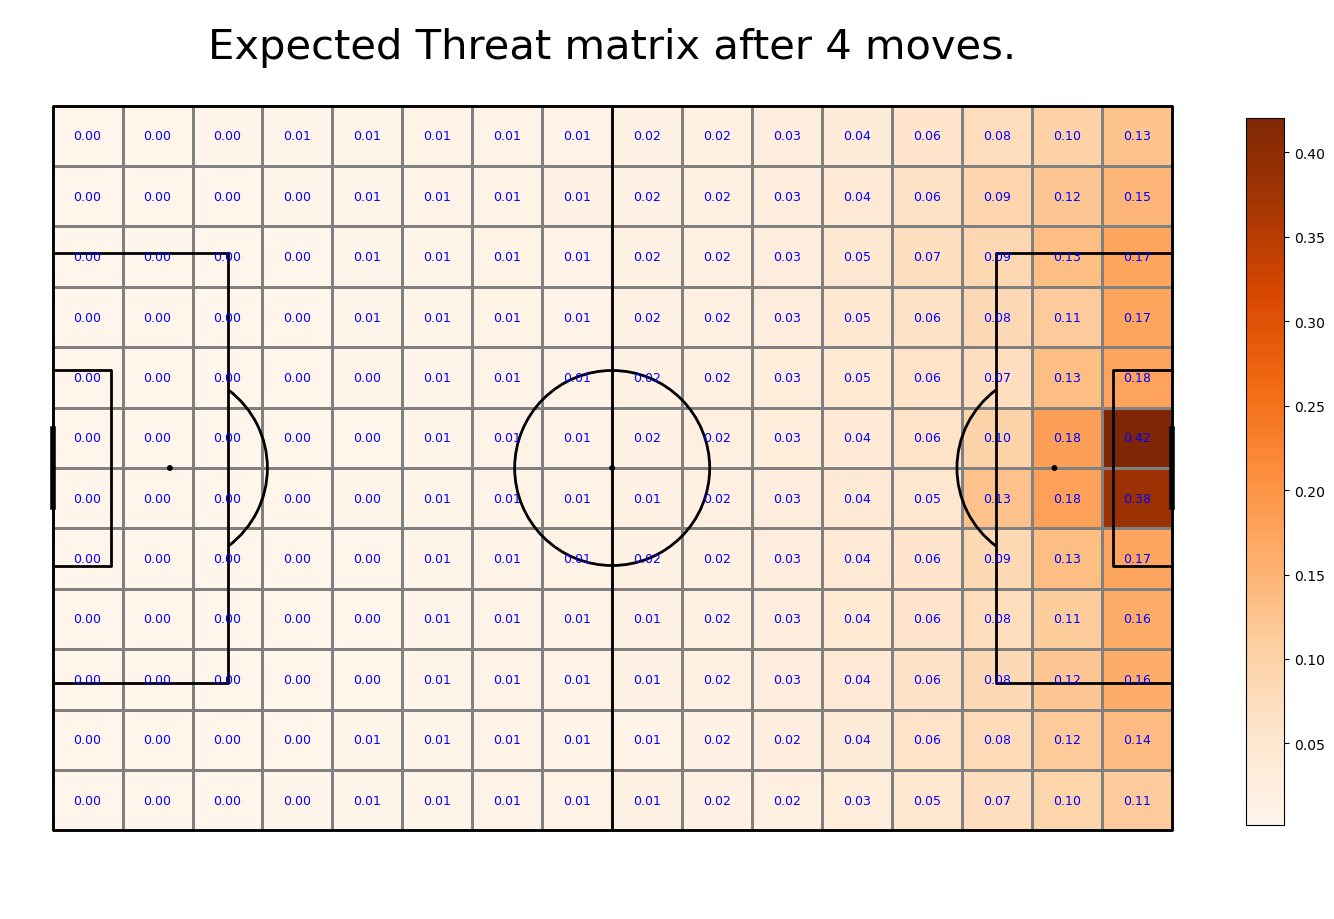

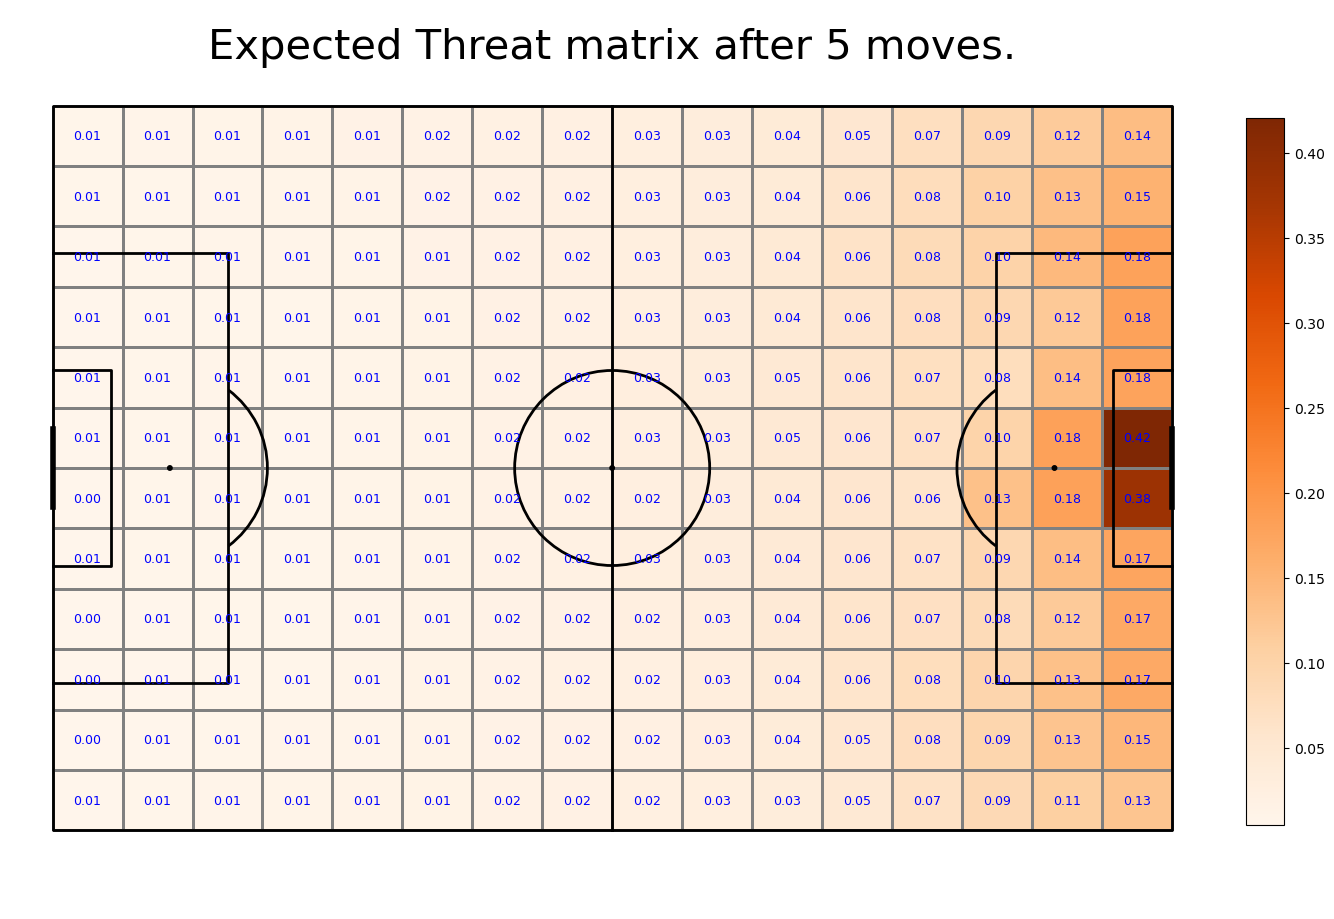

In [15]:
# Calculating the xT matrix

transition_matrices_array = np.array(transition_matrices)
xT = np.zeros((12,16))
for i in range(5):
    shoot_expected_payoff = goal_probability*shot_probability
    move_expected_payoff = move_probability*(np.sum(np.sum(transition_matrices_array*xT, axis=2),axis=1).reshape(16,12).T)
    xT = shoot_expected_payoff + move_expected_payoff

    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                        endnote_height=0.04, title_space=0, endnote_space=0)
    goal['statistic'] = xT
    pcm = pitch.heatmap(goal, cmap='Oranges', edgecolor='grey', ax=ax['pitch'])
    labels = pitch.label_heatmap(goal, color='blue', fontsize=9,
                                ax=ax['pitch'],ha='center',va='center', str_format="{0:,.2f}",zorder = 3)
    
    ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
    cbar = plt.colorbar(pcm, cax=ax_cbar)
    txt = 'Expected Threat matrix after '+ str(i+1) + ' moves.'
    fig.suptitle(txt, fontsize = 30)
    plt.show()

## Applying xT value to moving actions
As the next step we calculate for progressive and successful events the xT added. From the matrix we get the xT value for starting and ending zone and subtract the first one from the latter one. This is one way of doing that. The other would be to keep all moving the ball actions, calculate xT for the successful ones and assign -xT value of the starting zone for the unsuccessful ones.

In [ ]:
#filtering for only successful moves
successful_moves = move_df[move_df.apply(lambda x:{'id':1801} in x.tags, axis=1)]
#calculate the xT
successful_moves['xT_added'] = successful_moves.apply(lambda row: xT[row.end_sector[1]-1][row.end_sector[0] - 1]
                                                      - xT[row.start_sector[1]-1][row.start_sector[0]-1], axis=1)
#-1 is because in python arrays, the points on the 12x16 are labelled from 0-11 and 0-15 instead of 1-12 and 1-16

#filtering for only progressive(+) xT actions
value_adding_actions = successful_moves[successful_moves['xT_added']>0]

## Finding out players with the highes xT

In [42]:
#group by player
xT_by_player = value_adding_actions.groupby(['playerId'])['xT_added'].sum().reset_index()

player_df = pd.read_json(r'C:\Users\elvin\Documents\Soccermatics\Wyscout\players.json',encoding='unicode-escape')
player_df.rename(columns={'wyId':'playerId'}, inplace=True)
player_df['position'] = player_df.apply(lambda x: x.role['name'], axis=1)
to_merge = player_df[['playerId','shortName','position']]

summary = xT_by_player.merge(to_merge, how='left', on = ['playerId'])

minutes_per_game = pd.read_json(r'C:\Users\elvin\Documents\Soccermatics\Wyscout\minutes_played_per_game_England.json',encoding='unicode-escape')

#filtering for players with over 400 mins played
minutes = minutes_per_game.groupby(['playerId'])['minutesPlayed'].sum().reset_index()
summary = minutes.merge(summary,how='left', on=['playerId'])
summary = summary.fillna(0)
summary = summary[summary['minutesPlayed']>400]
#calculating per 90
summary['xT_per_90'] = summary['xT_added']*90/summary['minutesPlayed']

#adjusting for possession
percentage_df = pd.read_json(r'C:\Users\elvin\Documents\Soccermatics\Wyscout\player_possesion_England.json')
summary = summary.merge(percentage_df, how='left', on=['playerId'])

summary['xT_adjusted_per_90'] = (summary['xT_added']/summary['possesion'])*90/summary['minutesPlayed']
a = summary[['shortName','position','xT_added','xT_per_90','xT_adjusted_per_90']].sort_values(by='xT_adjusted_per_90',ascending=False)

## Challenge
1. Write the Calculating Expected Threat matrix section using for loops to get a better understanding of the algorithm!

2. Don’t remove unsuccessful and non-progressive actions. Assign -xT for unsuccessful ones!

In [52]:
#2.

#group by player
xT_by_player = successful_moves.groupby(['playerId'])['xT_added'].sum().reset_index()

player_df = pd.read_json(r'C:\Users\elvin\Documents\Soccermatics\Wyscout\players.json',encoding='unicode-escape')
player_df.rename(columns={'wyId':'playerId'}, inplace=True)
player_df['position'] = player_df.apply(lambda x: x.role['name'], axis=1)
to_merge = player_df[['playerId','shortName','position']]

summary_with_negs = xT_by_player.merge(to_merge, how='left', on = ['playerId'])

minutes_per_game = pd.read_json(r'C:\Users\elvin\Documents\Soccermatics\Wyscout\minutes_played_per_game_England.json',encoding='unicode-escape')

#filtering for players with over 400 mins played
minutes = minutes_per_game.groupby(['playerId'])['minutesPlayed'].sum().reset_index()
summary_with_negs = minutes.merge(summary_with_negs,how='left', on=['playerId'])
summary_with_negs = summary_with_negs.fillna(0)
summary_with_negs = summary_with_negs[summary_with_negs['minutesPlayed']>400]
#calculating per 90
summary_with_negs['xT_per_90'] = summary_with_negs['xT_added']*90/summary_with_negs['minutesPlayed']

#adjusting for possession
percentage_df = pd.read_json(r'C:\Users\elvin\Documents\Soccermatics\Wyscout\player_possesion_England.json')
summary_with_negs = summary_with_negs.merge(percentage_df, how='left', on=['playerId'])

summary_with_negs['xT_adjusted_per_90'] = (summary_with_negs['xT_added']/summary_with_negs['possesion'])*90/summary_with_negs['minutesPlayed']
summary_with_negs[['shortName','position','xT_added','xT_per_90','xT_adjusted_per_90']].sort_values(by='xT_adjusted_per_90',ascending=False)

,shortName,position,xT_added,xT_per_90,xT_adjusted_per_90
27,Fàbregas,Midfielder,22.451065,0.839118,1.530500
78,J. Shelvey,Midfielder,13.895260,0.528560,1.221750
68,P. Pogba,Midfielder,17.164633,0.691812,1.217969
125,C. Brunt,Midfielder,10.707455,0.479200,1.125824
39,Philippe Coutinho,Forward,8.266882,0.656102,1.115402
...,...,...,...,...,...
382,O. Burke,Midfielder,-0.249203,-0.054174,-0.113077
364,Bernardo Silva,Midfielder,-1.465330,-0.081257,-0.116527
192,S. Berahino,Forward,-0.400419,-0.066985,-0.164922
327,B. Afobe,Forward,-0.684155,-0.104186,-0.212963
